Dataset Description
The competition data comprises over fifty anonymized health characteristics linked to three age-related conditions. Your goal is to predict whether a subject has or has not been diagnosed with one of these conditions -- a binary classification problem.

Note that this is a Code Competition, in which the actual test set is hidden. In this version, we give some sample data in the correct format to help you author your solutions. When your submission is scored, this example test data will be replaced with the full test set. There are about 400 rows in the full test set.

Files and Field Descriptions
train.csv - The training set.
Id Unique identifier for each observation.
AB-GL Fifty-six anonymized health characteristics. All are numeric except for EJ, which is categorical.
Class A binary target: 1 indicates the subject has been diagnosed with one of the three conditions, 0 indicates they have not.
test.csv - The test set. Your goal is to predict the probability that a subject in this set belongs to each of the two classes.
greeks.csv - Supplemental metadata, only available for the training set.
Alpha Identifies the type of age-related condition, if present.
A No age-related condition. Corresponds to class 0.
B, D, G The three age-related conditions. Correspond to class 1.
Beta, Gamma, Delta Three experimental characteristics.
Epsilon The date the data for this subject was collected. Note that all of the data in the test set was collected after the training set was collected.
sample_submission.csv - A sample submission file in the correct format. See the Evaluation page for more details.

#### Notes

Positive class is minority. About 20% are positive

In [136]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer, StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [178]:
data = pd.read_csv("data/train.csv", index_col="Id").dropna() # EJ is categorical
ej_bins = data.EJ.map({"A": 0, "B": 1})
data.EJ = ej_bins

greeks = pd.read_csv("data/greeks.csv", index_col="Id")

In [169]:
# data = data.merge(greeks[["Beta", "Gamma", "Delta"]], left_index=True, right_index=True)

In [179]:
X_train, X_test, y_train, y_test = train_test_split(data.drop("Class", axis=1), data.Class, test_size=0.2, random_state=42)

In [180]:
training = pd.concat([X_train, y_train], axis=1)

In [175]:
# training = pd.concat([training.drop("Beta", axis=1), pd.get_dummies(training["Beta"], drop_first=True)], axis=1)
# training = pd.concat([training.drop("Gamma", axis=1), pd.get_dummies(training["Gamma"], drop_first=True)], axis=1)
# training = pd.concat([training.drop("Delta", axis=1), pd.get_dummies(training["Delta"], drop_first=True)], axis=1)

In [181]:
training

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
Id,,,,,,,,,,,,,,,,,,,,,
14713ec51d95,0.175193,4756.23170,85.200147,5.634991,8.138688,3.689773,0.025578,11.854062,4.821208,4112.277220,...,4.333945,0.49706,0.209963,11.725171,72.611063,1273.730670,30.568015,77.233302,0.141851,0
29cba3a7b8dc,0.871692,4085.77675,142.305060,17.107828,8.138688,13.182192,0.025578,15.773906,1.229900,4792.753560,...,4.140112,1.36387,0.501202,34.119736,88.348834,8597.759661,20.811553,29.251356,0.238408,0
d1fa22631c9c,0.183739,7820.05334,85.200147,7.922126,8.138688,3.685344,0.041412,12.553584,1.229900,4092.294230,...,2.833787,0.49706,0.392834,19.227234,72.611063,1401.381486,26.590266,76.470704,0.436765,0
8e22648bf996,0.504214,1042.53358,85.200147,11.632332,12.947436,1.674351,0.025578,3.396778,1.229900,6769.807150,...,7.773857,1.06459,0.203190,24.101482,119.053609,1668.276405,31.412682,107.645916,0.066283,0
7bcb9a31014b,0.239288,1143.75008,168.031446,70.577533,8.259300,7.051764,0.194271,10.322676,5.032048,3337.478930,...,0.173229,0.49706,0.067730,18.548188,111.816355,36672.254600,19.751068,65.493408,21.978000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1e4b78cada73,0.213650,4976.76630,85.200147,43.039009,8.138688,4.092858,0.025578,10.599964,4.705246,5951.786955,...,0.173229,0.49706,0.067730,14.901804,311.325620,23844.395170,25.946533,61.194310,21.978000,0
2f4e5de3de9c,0.653769,11786.13326,85.200147,168.541837,22.085106,6.316467,0.025578,11.186050,1.229900,5894.211015,...,11.025166,1.49379,0.067730,22.413169,90.029503,7835.870097,40.309593,100.806968,0.017348,1
7af31043202c,0.397389,1299.46256,117.170886,42.060357,8.138688,5.164797,0.025578,12.361373,1.229900,7540.965995,...,26.623333,0.87348,0.440245,25.854909,280.225523,2961.298602,34.690883,32.134568,0.045339,1


In [182]:
training.corr().style.background_gradient(cmap="magma")

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
AB,1.000000,0.291743,0.188786,0.457076,0.121012,0.506237,0.140966,0.210672,0.077640,0.137431,0.305022,0.427857,0.213968,0.219915,0.277243,0.069281,0.095137,0.300349,-0.006715,0.375941,0.049225,-0.040108,0.197367,-0.119315,-0.067888,-0.123787,-0.088338,0.072685,-0.180159,0.285210,-0.164664,0.202637,0.099165,0.045002,0.049678,0.213162,-0.023032,0.135036,0.115597,0.144068,-0.002999,0.056477,-0.047813,0.359997,0.104533,0.046010,0.036660,0.130187,-0.002577,0.016524,0.180299,-0.056750,-0.025531,0.181683,0.009476,-0.140920,0.301822
AF,0.291743,1.000000,0.020187,0.155651,0.030859,0.205141,-0.032053,0.248298,0.083825,-0.016018,0.137897,0.216500,0.295717,0.020390,0.188335,0.018096,0.063842,0.126154,-0.062754,0.084046,-0.052515,-0.008979,0.045466,0.162160,-0.093642,-0.169180,-0.150363,0.037397,-0.012696,0.328180,0.051718,0.257172,0.123799,-0.047983,0.016476,0.099801,-0.114374,0.084273,0.133305,0.153155,0.127455,-0.048612,-0.000045,0.083759,0.100128,0.071783,-0.010571,0.191045,0.009982,-0.007526,0.063123,0.052827,-0.169861,0.203523,0.137547,-0.167653,0.309218
AH,0.188786,0.020187,1.000000,0.015628,0.850628,-0.004776,0.615232,0.102011,0.135722,-0.028968,0.065731,0.188514,0.149801,0.016551,0.458163,0.116836,-0.044336,0.126896,-0.044226,0.791685,0.749512,-0.027167,0.760605,0.060820,0.087863,0.374771,0.143833,0.172480,0.162123,0.158651,-0.076655,-0.024682,-0.030107,0.814701,0.024760,0.782579,0.260609,0.058508,-0.023244,0.058795,-0.108901,0.786087,-0.008012,0.224267,-0.010256,-0.036975,0.055879,-0.021834,-0.010055,0.007393,-0.016186,-0.008567,-0.015702,-0.070621,-0.085219,0.010868,0.014901
AM,0.457076,0.155651,0.015628,1.000000,0.122985,0.212142,-0.027028,0.139235,0.027642,0.049003,0.145736,0.113349,0.237203,0.019524,-0.009940,-0.003811,0.026708,0.262510,-0.048254,0.164112,-0.036097,-0.031216,0.016688,-0.060890,-0.011864,-0.232212,-0.093011,0.092473,-0.153945,0.278513,-0.093799,0.127950,0.053190,-0.038680,-0.031223,0.015877,-0.045156,0.078584,0.021111,0.141195,0.079670,-0.046906,-0.010362,0.026940,0.007762,0.061987,-0.027294,0.123558,-0.011388,0.023508,0.057889,-0.025897,-0.038490,0.083713,0.132895,-0.145481,0.235560
AR,0.121012,0.030859,0.850628,0.122985,1.000000,0.003966,0.652027,0.092523,0.087801,-0.069535,0.017872,0.192988,0.199458,0.005415,0.429303,0.033898,-0.047092,0.024900,-0.026366,0.694880,0.773932,-0.166102,0.794544,0.125171,0.085329,0.380490,0.108973,0.232605,0.218795,0.270374,-0.009972,-0.032655,-0.006821,0.861877,-0.053304,0.828730,0.232753,0.055839,-0.008578,0.058151,-0.069983,0.829625,0.006301,-0.015782,0.004634,0.018462,0.030070,0.032115,-0.008525,0.066796,-0.048845,0.035739,-0.023134,-0.169758,0.037020,0.006939,0.047542
AX,0.506237,0.205141,-0.004776,0.212142,0.003966,1.000000,0.079454,0.321464,-0.006454,0.120942,0.206993,0.455139,0.151369,0.042419,0.168569,-0.022737,0.145801,0.170830,0.095961,0.146185,0.061957,-0.044665,0.107086,0.068863,-0.043495,-0.000696,0.020472,0.008823,-0.041983,0.196036,-0.023783,0.222519,-0.027426,0.026772,0.016527,0.101480,-0.050882,0.236083,-0.029446,-0.035715,0.131694,-0.025159,-0.022287,0.209603,-0.033171,0.039816,0.154522,-0.039975,-0.023113,0.046611,0.238947,0.072776,0.127959,0.114446,0.115227,0.032981,0.112362
AY,0.140966,-0.032053,0.615232,-0.027028,0.652027,0.079454,1.000000,0.031994,0.171002,-0.014686,-0.023799,0.328170,0.115830,0.056670,0.516523,0.009952,-0.016654,-0.011261,-0.022187,0.544299,0.549618,-0.064862,0.658872,0.083880,0.031669,0.283961,0.095027,0.151796,0.178885,0.154322,-0.007194,-0.002072,-0.040502,0.605358,-0.002724,0.659320,0.063586,-0.018896,-0.034273,-0.062318,-0.047923,0.764199,-0.001780,-0.038474,-0.019304,0.066590,0.056459,-0.070214,-0.013173,0.004768,-0.024894,0.019827,-0.012721,-0.051360,-0.020541,0.112791,-0.015959
AZ,0.210672,0.248298,0.102011,0.139235,0.092523,0.321464,0.031994,1.000000,0.0242

In [188]:
training.groupby("Class").agg(["mean", "median"])

AB                     AF                      AH             \
           mean    median         mean      median        mean     median   
Class                                                                       
0      0.408560  0.324748  3174.538284  2864.46446  114.342036  85.200147   
1      0.692226  0.572582  5044.576630  3997.38504  119.433308  85.200147   

              AM                    AR            ...          GE             \
            mean     median       mean    median  ...        mean     median   
Class                                             ...                          
0      29.349849  18.498381   9.922396  8.138688  ...  138.775047  72.611063   
1      65.811637  30.959161  11.364091  8.138688  ...  111.494571  72.611063   

                 GF                      GH                    GI             \
               mean       median       mean     median       mean     median   
Class                                                                          
0      17735.759921  9835.155513  31.353976  30.731739  52.457993  43.370350   
1       7900.281205  4468.337338  31.770762  29.025661  56.150220  43.904683   

              GL            
            mean    median  
Class                       
0      10.089229  2.197800  
1       4.370264  0.094471  

[2 rows x 112 columns]

In [208]:
axes[1][1]

<Axes: >

/tmp/ipykernel_844913/3210861860.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(x=[training[training.Class == 1][feature],


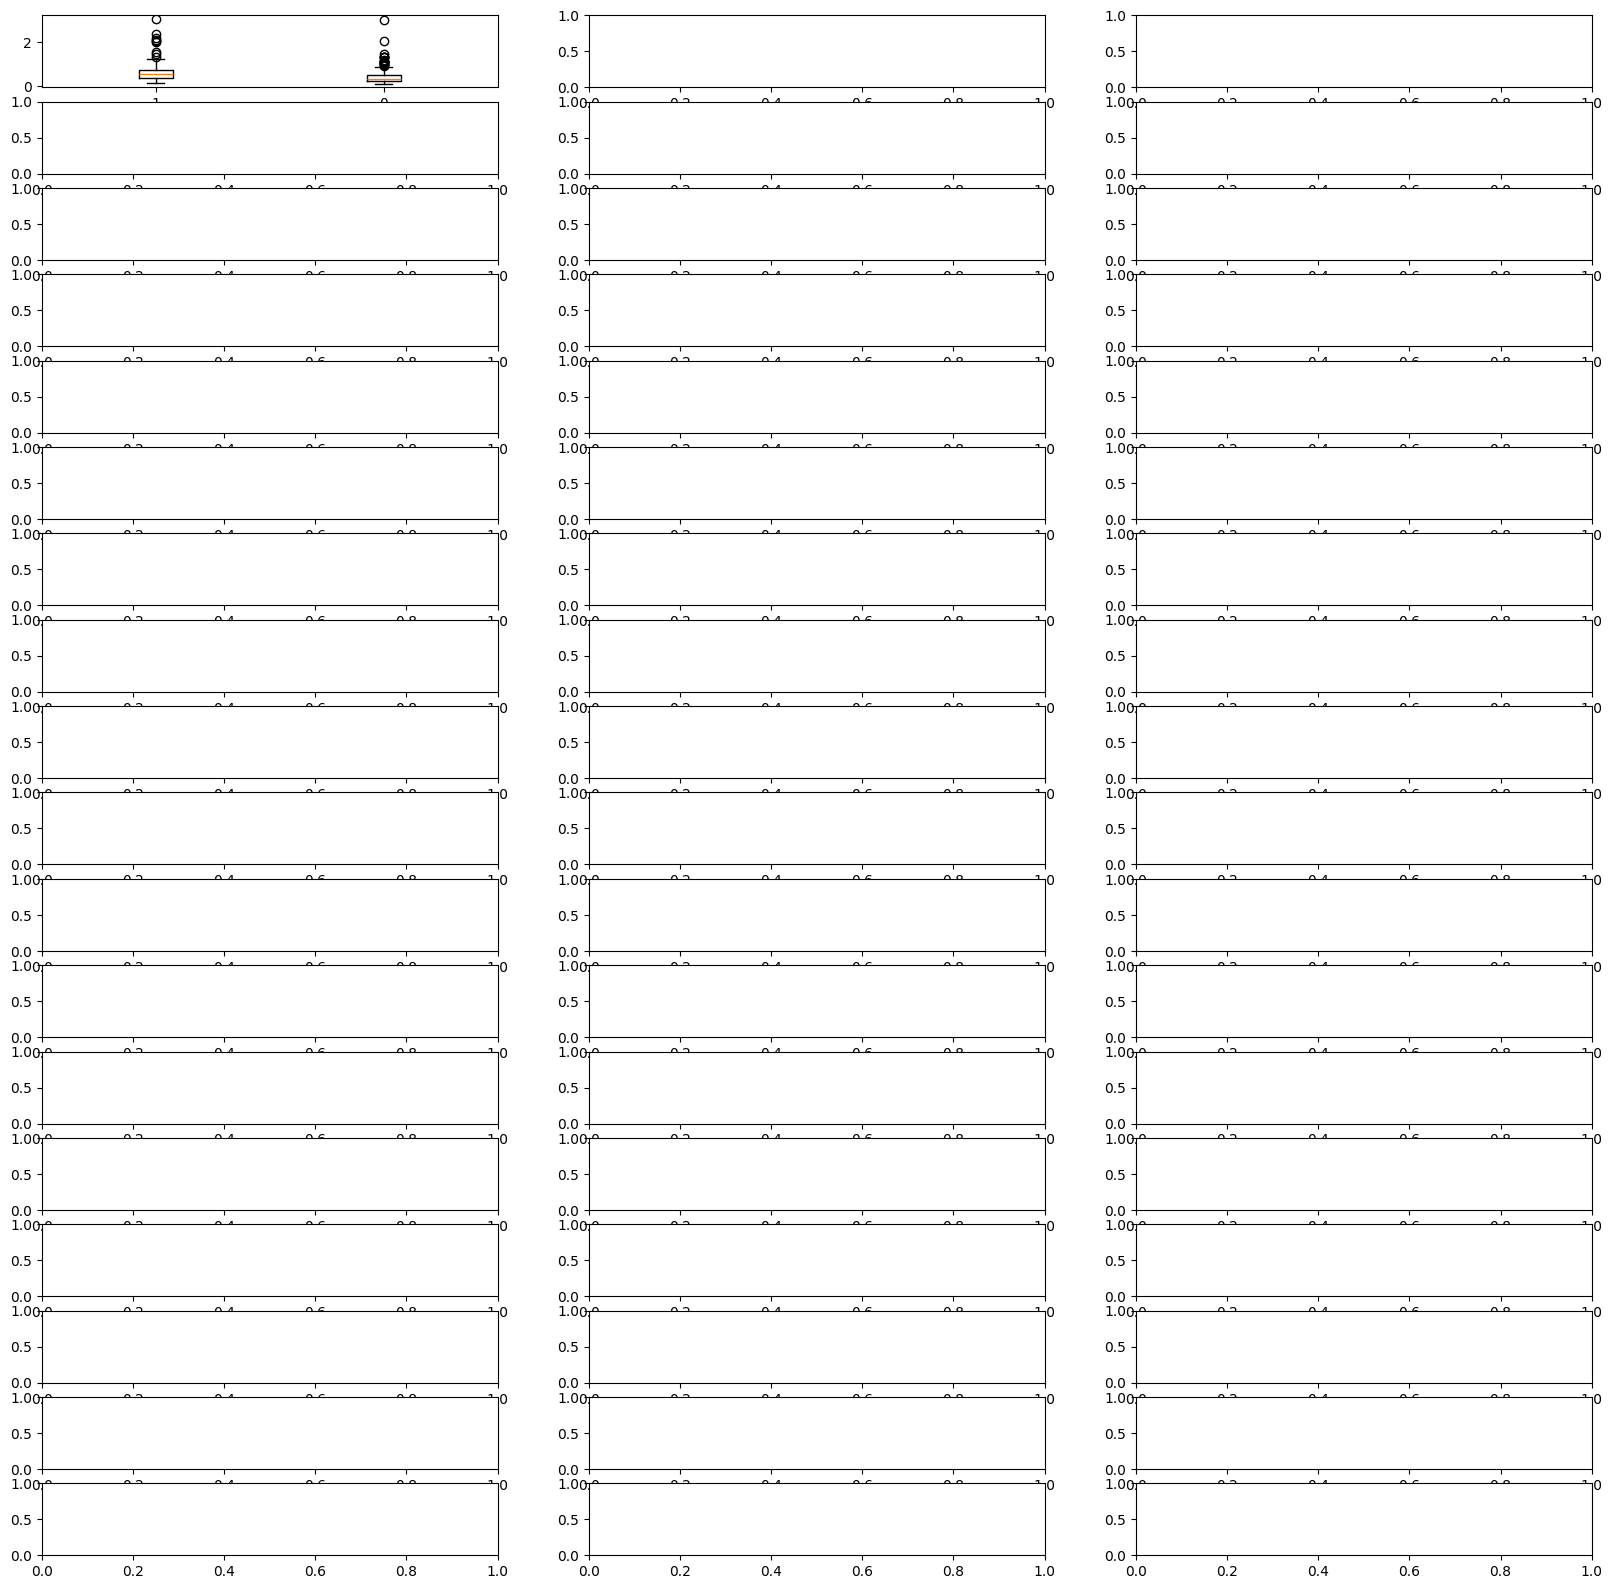

/tmp/ipykernel_844913/3210861860.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(x=[training[training.Class == 1][feature],
/tmp/ipykernel_844913/3210861860.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(x=[training[training.Class == 1][feature],
/tmp/ipykernel_844913/3210861860.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(x=[training[training.Class == 1][feature],
/tmp/ipykernel_844913/3210861860.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dr

IndexError: index 54 is out of bounds for axis 0 with size 54

In [209]:
features = X_train.columns

f, axes =plt.subplots(ncols=3, nrows=len(features)//3, figsize=(20, 20))
axes=axes.flatten()

for i, feature in enumerate(features):
    axes[i].boxplot(x=[training[training.Class == 1][feature], 
                       training[training.Class == 0][feature]], 
                       tick_labels=["1", "0"])
    plt.show()